# Uncovering the Drivers of Housing Prices in Beijing: The Influence of Location and Time

In [1]:
# Import packages
library(tidyverse)
library(lubridate) 
library(repr)

Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Read and Load Data Set

In [2]:
# Load the dataset
housing_data <- read_csv("dsci310-group02-project/data/new.csv", locale = locale(encoding = "UTF-8")) %>% mutate(floor = str_trim(str_extract(floor,"( .*)"), side = "both"))

# Explore the structure and summary statistics of the dataset
head(housing_data)
tail(housing_data)
summary(housing_data)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 318851 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): url, id, floor, constructionTime
dbl  (21): Lng, Lat, Cid, DOM, followers, totalPrice, price, square, livingR...
date  (1): tradeTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,⋯,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
https://bj.lianjia.com/chengjiao/101084782030.html,101084782030,116.4755,40.01952,1.111027e+12,2016-08-09,1464,106,415.0,31680,⋯,1,2005,3,6,0.217,1,0,1,7,56021
https://bj.lianjia.com/chengjiao/101086012217.html,101086012217,116.4539,39.88153,1.111027e+12,2016-07-28,903,126,575.0,43436,⋯,1,2004,4,6,0.667,1,1,0,7,71539
https://bj.lianjia.com/chengjiao/101086041636.html,101086041636,116.5620,39.87714,1.111041e+12,2016-12-11,1271,48,1030.0,52021,⋯,4,2005,3,6,0.500,1,0,0,7,48160
https://bj.lianjia.com/chengjiao/101086406841.html,101086406841,116.4380,40.07611,1.111043e+12,2016-09-30,965,138,297.5,22202,⋯,1,2008,1,6,0.273,1,0,0,6,51238
https://bj.lianjia.com/chengjiao/101086920653.html,101086920653,116.4284,39.88623,1.111027e+12,2016-08-28,927,286,392.0,48396,⋯,4,1960,2,2,0.333,0,1,1,1,62588
https://bj.lianjia.com/chengjiao/101087277815.html,101087277815,116.4663,39.99136,1.111027e+12,2016-07-22,861,57,275.6,52000,⋯,4,2005,3,6,0.333,1,1,0,7,67738


url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,⋯,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
https://bj.lianjia.com/chengjiao/BJYZ92303482.html,BJYZ92303482,116.5469,39.75524,1.111027e+12,2016-06-09,1,8,355.5,26491,⋯,3,2009,4,6,0.500,1,1,0,3,36545
https://bj.lianjia.com/chengjiao/BJYZ92311192.html,BJYZ92311192,116.5469,39.75524,1.111027e+12,2016-06-10,1,8,350.0,20580,⋯,4,2003,1,6,0.333,0,1,0,3,36545
https://bj.lianjia.com/chengjiao/BJYZ92320171.html,BJYZ92320171,116.4975,39.81012,1.111027e+12,2016-06-10,NaN,1,108.8,31006,⋯,1,2009,1,6,0.222,1,0,1,3,54282
https://bj.lianjia.com/chengjiao/BJYZ92324217.html,BJYZ92324217,116.4973,39.80408,1.111027e+12,2016-06-05,1,2,359.0,35138,⋯,4,2000,3,6,0.500,1,1,0,3,46927
https://bj.lianjia.com/chengjiao/BJYZ92333313.html,BJYZ92333313,116.5018,39.79935,1.111027e+12,2016-06-12,NaN,4,720.0,40373,⋯,4,2003,4,2,0.500,0,1,0,3,54842
https://bj.lianjia.com/chengjiao/BJYZ92363553.html,BJYZ92363553,116.4975,39.81012,1.111027e+12,2016-06-11,1,0,450.0,48675,⋯,4,δ֪,4,6,1.000,1,0,1,3,54282


     url                 id                 Lng             Lat       
 Length:318851      Length:318851      Min.   :116.1   Min.   :39.63  
 Class :character   Class :character   1st Qu.:116.3   1st Qu.:39.89  
 Mode  :character   Mode  :character   Median :116.4   Median :39.93  
                                       Mean   :116.4   Mean   :39.95  
                                       3rd Qu.:116.5   3rd Qu.:40.00  
                                       Max.   :116.7   Max.   :40.25  
                                                                      
      Cid              tradeTime               DOM            followers      
 Min.   :1.111e+12   Min.   :2002-06-01   Min.   :   1.00   Min.   :   0.00  
 1st Qu.:1.111e+12   1st Qu.:2013-11-30   1st Qu.:   1.00   1st Qu.:   0.00  
 Median :1.111e+12   Median :2015-09-12   Median :   6.00   Median :   5.00  
 Mean   :1.129e+12   Mean   :2015-04-17   Mean   :  28.82   Mean   :  16.73  
 3rd Qu.:1.111e+12   3rd Qu.:2016-07-31   

## Cleaning and Wrangling Data

In [3]:
# Remove some not useful columns
housing_data <- select(housing_data, -url, -id, -Cid)

# Convert character variables to appropriate types
housing_data <- housing_data %>%
  mutate(tradeTime = as.Date(tradeTime),
         livingRoom = as.integer(livingRoom),
         drawingRoom = as.integer(drawingRoom),
         bathroom = as.integer(bathRoom),
         constructionTime = as.integer(constructionTime))

# Also remove variables with Chinese characters
housing_data <- select(housing_data, -floor)

# Check for missing values
summary(housing_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `constructionTime = as.integer(constructionTime)`.
Caused by warning:
! NAs introduced by coercion”


      Lng             Lat          tradeTime               DOM         
 Min.   :116.1   Min.   :39.63   Min.   :2002-06-01   Min.   :   1.00  
 1st Qu.:116.3   1st Qu.:39.89   1st Qu.:2013-11-30   1st Qu.:   1.00  
 Median :116.4   Median :39.93   Median :2015-09-12   Median :   6.00  
 Mean   :116.4   Mean   :39.95   Mean   :2015-04-17   Mean   :  28.82  
 3rd Qu.:116.5   3rd Qu.:40.00   3rd Qu.:2016-07-31   3rd Qu.:  37.00  
 Max.   :116.7   Max.   :40.25   Max.   :2018-01-28   Max.   :1677.00  
                                                      NA's   :157977   
   followers         totalPrice          price            square       
 Min.   :   0.00   Min.   :    0.1   Min.   :     1   Min.   :   6.90  
 1st Qu.:   0.00   1st Qu.:  205.0   1st Qu.: 28050   1st Qu.:  57.90  
 Median :   5.00   Median :  294.0   Median : 38737   Median :  74.26  
 Mean   :  16.73   Mean   :  349.0   Mean   : 43530   Mean   :  83.24  
 3rd Qu.:  18.00   3rd Qu.:  425.5   3rd Qu.: 53820   3rd Qu.:  

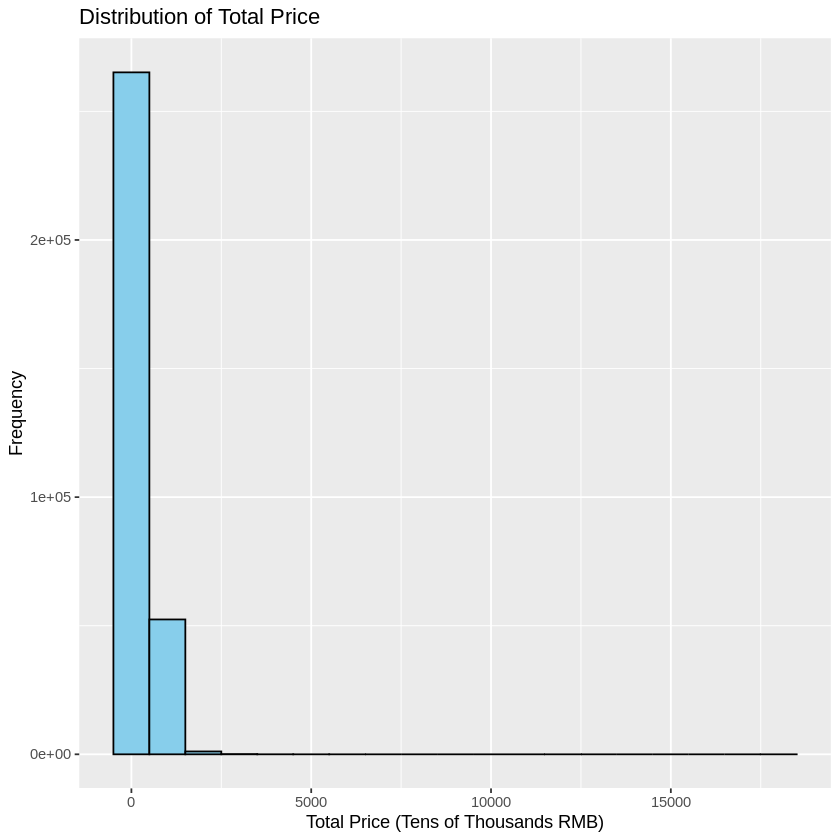

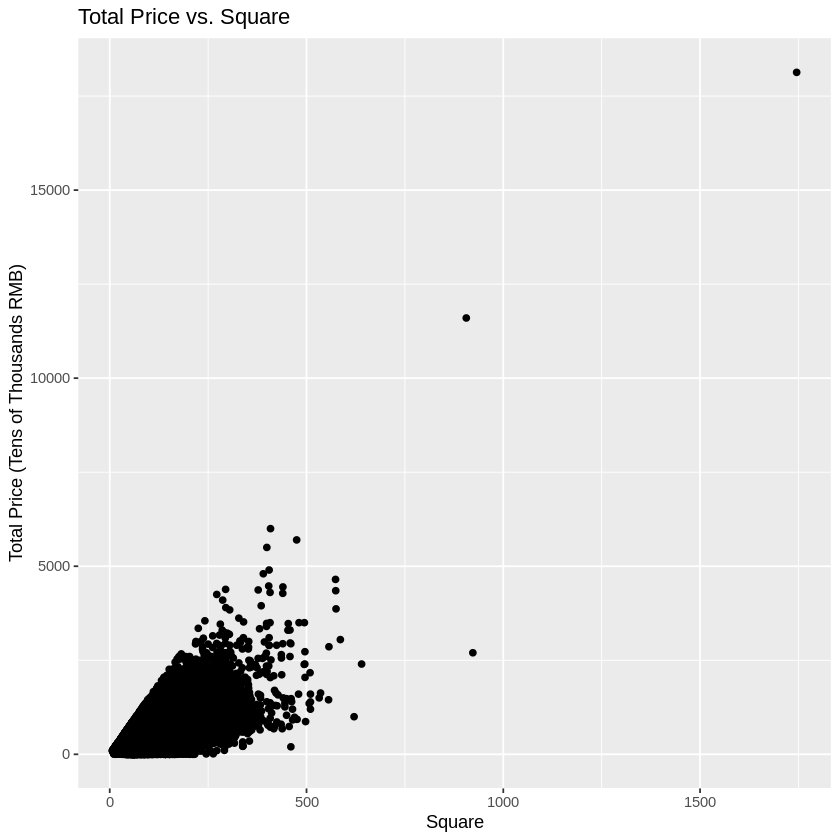

In [10]:
# Visualize distribution of numeric variables using histograms
ggplot(housing_data, aes(x = totalPrice)) +
  geom_histogram(binwidth = 1000, fill = "skyblue", color = "black") +
  labs(title = "Distribution of Total Price",
       x = "Total Price (Tens of Thousands RMB)",
       y = "Frequency")

# Explore relationships between variables using scatter plots
ggplot(housing_data, aes(x = square, y = totalPrice)) +
  geom_point() +
  labs(title = "Total Price vs. Square",
       x = "Square",
       y = "Total Price (Tens of Thousands RMB)")